<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S11/blob/master/S11_withAlbumentations%2CModel%2COneCyclePolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h3>Install Albumentations and Apex librabies</h3>**

In [0]:
%matplotlib inline

In [2]:
!pip install -U git+https://github.com/albu/albumentations
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-rgaq3puf
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-rgaq3puf
     |████████████████████████████████| 634kB 6.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=c49ec72083afd3d50e9226fe3ae4c9ce31697b7311eda5ecee2cccc86cc82883
  Stored in directory: /tmp/pip-ephem-wheel-cache-kgsvces5/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=de72d1db8861b256f1f9ac811e0dc03d9ebb114c409cc5b66a807ff3e1c7d918
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

**<h3>Mount Drive<h3>**

In [4]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session11'
sys.path.append(folder)

In [0]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import lr_finder

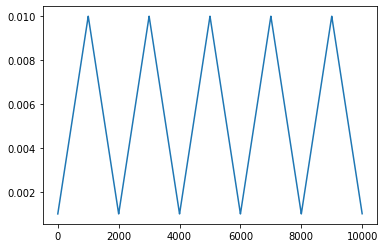

In [7]:
import matplotlib.pyplot as plt
import numpy as np

lr_plot=[]
def CyclicTriangle(iterations,min_lr,max_lr,step_size):
  for i in range(iterations):
    cycle = np.floor(1+i/(2*step_size))
    x = np.abs((i/step_size)-2*cycle+1)
    lr = min_lr + ((max_lr-min_lr)*(1-x))
    lr_plot.append(lr)
  plt.plot(list(range(iterations)),lr_plot)
CyclicTriangle(iterations=10000,min_lr=0.001,max_lr=0.01,step_size=1000)

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [8]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



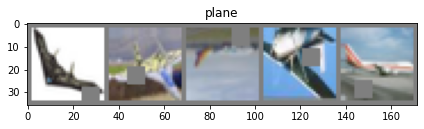

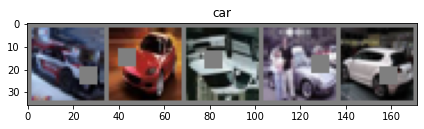

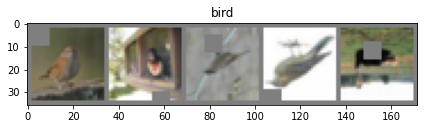

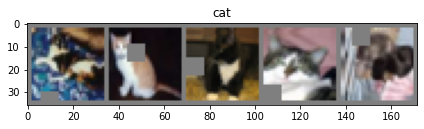

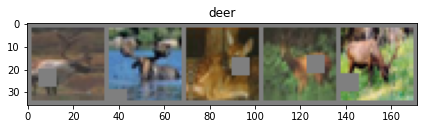

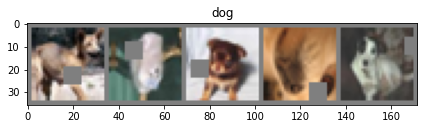

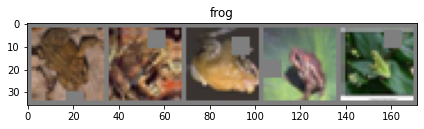

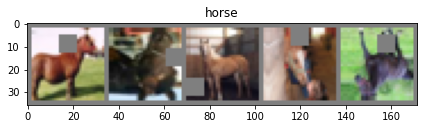

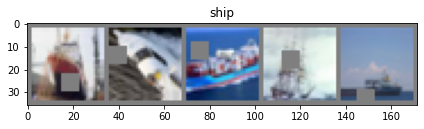

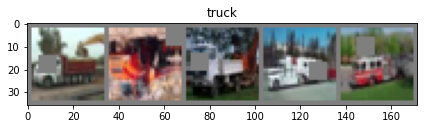

In [9]:
show_images.show_random_images(trainloader, classes)

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01,momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr = 0.01, total_steps=None, epochs=24, steps_per_epoch=1, pct_start=0.2, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0)
#lrfinder = lr_finder.LRFinder(resnet, optimiser, criterion, device="cuda")
#lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")

In [0]:
#import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(resnet.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0001)
# scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)

In [12]:
train_loss=[]
train_acc=[]
EPOCHS = 24
LR_list = []
for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
      LR_list.append(optimizer.param_groups[0]['lr'])
      train_loss, train_acc = train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
      scheduler.step()
      test_loss , test_acc = train_test.test(resnet, device, criterion, testloader)
      #scheduler.step()

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.001


Loss=1.4573603868484497 Batch_id=97 Accuracy=35.70: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 4867/10000 (48.67%)

EPOCH: 2 LR: 0.0033684210526315787


Loss=1.0643742084503174 Batch_id=97 Accuracy=52.02: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5875/10000 (58.75%)

EPOCH: 3 LR: 0.005736842105263157


Loss=1.0899876356124878 Batch_id=97 Accuracy=59.52: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 6087/10000 (60.87%)

EPOCH: 4 LR: 0.008105263157894737


Loss=0.9659968018531799 Batch_id=97 Accuracy=64.78: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6848/10000 (68.48%)

EPOCH: 5 LR: 0.009895834375


Loss=0.7618688941001892 Batch_id=97 Accuracy=69.49: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7249/10000 (72.49%)

EPOCH: 6 LR: 0.00937500625


Loss=0.8313787579536438 Batch_id=97 Accuracy=73.95: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7431/10000 (74.31%)

EPOCH: 7 LR: 0.008854178125


Loss=0.6221190690994263 Batch_id=97 Accuracy=77.15: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7888/10000 (78.88%)

EPOCH: 8 LR: 0.00833335


Loss=0.5445863008499146 Batch_id=97 Accuracy=78.65: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7995/10000 (79.95%)

EPOCH: 9 LR: 0.007812521875


Loss=0.48987752199172974 Batch_id=97 Accuracy=81.21: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8160/10000 (81.60%)

EPOCH: 10 LR: 0.00729169375


Loss=0.3992170989513397 Batch_id=97 Accuracy=82.56: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8145/10000 (81.45%)

EPOCH: 11 LR: 0.006770865625000001


Loss=0.5538990497589111 Batch_id=97 Accuracy=83.89: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8371/10000 (83.71%)

EPOCH: 12 LR: 0.0062500375


Loss=0.3698839247226715 Batch_id=97 Accuracy=85.35: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8383/10000 (83.83%)

EPOCH: 13 LR: 0.005729209375


Loss=0.38493096828460693 Batch_id=97 Accuracy=86.59: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8496/10000 (84.96%)

EPOCH: 14 LR: 0.0052083812500000005


Loss=0.34587565064430237 Batch_id=97 Accuracy=87.91: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8564/10000 (85.64%)

EPOCH: 15 LR: 0.004687553125


Loss=0.31392425298690796 Batch_id=97 Accuracy=88.34: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8551/10000 (85.51%)

EPOCH: 16 LR: 0.004166725


Loss=0.30726227164268494 Batch_id=97 Accuracy=89.01: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8575/10000 (85.75%)

EPOCH: 17 LR: 0.0036458968750000004


Loss=0.34144529700279236 Batch_id=97 Accuracy=89.92: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8660/10000 (86.60%)

EPOCH: 18 LR: 0.0031250687499999995


Loss=0.24359075725078583 Batch_id=97 Accuracy=90.70: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8644/10000 (86.44%)

EPOCH: 19 LR: 0.0026042406249999995


Loss=0.2648760974407196 Batch_id=97 Accuracy=91.28: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8723/10000 (87.23%)

EPOCH: 20 LR: 0.0020834124999999995


Loss=0.2793930470943451 Batch_id=97 Accuracy=92.17: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8743/10000 (87.43%)

EPOCH: 21 LR: 0.0015625843750000003


Loss=0.21546581387519836 Batch_id=97 Accuracy=92.68: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8749/10000 (87.49%)

EPOCH: 22 LR: 0.0010417562499999995


Loss=0.25467047095298767 Batch_id=97 Accuracy=93.00: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8785/10000 (87.85%)

EPOCH: 23 LR: 0.0005209281250000003


Loss=0.1613200306892395 Batch_id=97 Accuracy=93.49: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8822/10000 (88.22%)

EPOCH: 24 LR: 9.999999999940612e-08


Loss=0.25274568796157837 Batch_id=97 Accuracy=93.38: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.0007, Accuracy: 8818/10000 (88.18%)



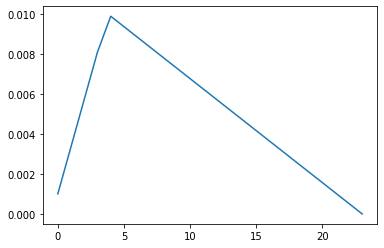

In [13]:
plt.plot(LR_list)

In [14]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 88.180 %


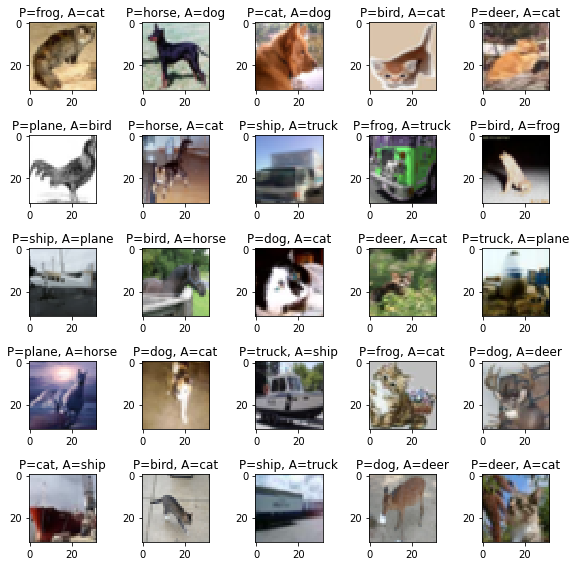

In [15]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [16]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 92 %
Accuracy of   cat : 42 %
Accuracy of  deer : 77 %
Accuracy of   dog : 83 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 80 %


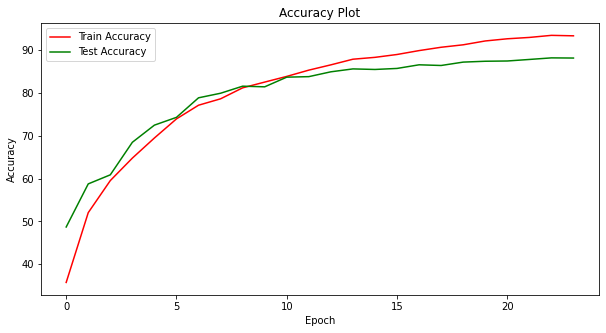

In [17]:
#import matplotlib.pyplot as plt
# fig, axs = plt.subplots(1,2, figsize=(15,10))

# axs[0].plot(train_acc)
# axs[0].plot(test_acc)
# axs[0].set_title("Accuracy Change")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(train_test.train_acc_epoch_end,color = 'r',label="Train Accuracy")
ax.plot(train_test.test_acc,color = 'g',label="Test Accuracy")
ax.set(title="Accuracy Plot", xlabel="Epoch", ylabel="Accuracy")
ax.legend()
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = resnet.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [resnet.layer1]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)

AttributeError: ignored

<Figure size 1656x2160 with 0 Axes>